In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
from itertools import combinations, permutations
from time import time
from numpy.random import random
from scipy.stats import spearmanr, chisquare
import pandas as pd
from fare.metrics import * #_count_inversions,_merge_parity,_merge_eq
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10,5
from sklearn.isotonic import IsotonicRegression
from yang_metrics import *

**load data from pickle files --- TOP 25 EXPERTS -- ALL DATA AT BOTTOM OF NOTEBOOK**

In [3]:
#top 25 experts' rankings of Wide recievers for 16 weeks of the season
# top25_dfs is a dictionary containing dataframes of rankings for one week.
# each column is a ranking of 55 players. The last column "Division" gives the group labels for each player

pkl_file = open('top25_dfs.pickle', 'rb')
top25_dfs = pickle.load(pkl_file)
pkl_file.close()

In [4]:
# Create version for just for top 10 players each week
dfs10 = {}
for week in range(1,17):
    dd = top25_dfs[week].drop('Division', axis=1)
    top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
    dfs10[week] = top25_dfs[week].drop('Division', axis=1).loc[top10].rank(ascending=True)
    dfs10[week]['Division'] = top25_dfs[week].loc[top10]['Division']

In [7]:
#check likelihood that rankings meet monotonicity condition
def meets_condition(df):
    # compute whole value counts not proportion for chi2 test
    dfs=[]
    for c in df.columns.values:
        dfs.append(df[c].value_counts())
    counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)

    # Fit IsotonicRegression
    x = list(range(1,len(counts)+1))
    y = counts.values
    ir = IsotonicRegression(increasing='auto')
    y_ = ir.fit_transform(x, y)

    pval = chisquare(y, f_exp=y_)[1]
    #small pvalue means we reject he null hypothesis that the samples come from the same distribution
    return pval > 0.05

**Single week: check monotonocity condition for entire ranking vs top10**

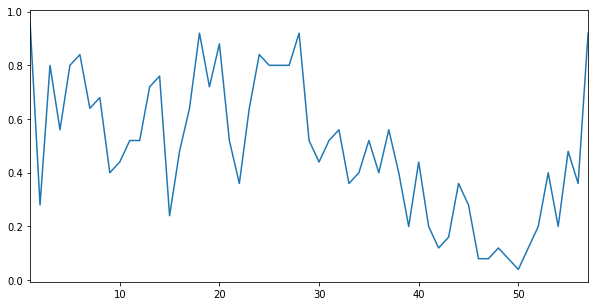

In [6]:
df = top25_dfs[4].drop('Division', axis=1).rank(ascending=True)
df = df[top25_dfs[4]['Division']==1.]
# r1 = df[df['Division']==0.]['Rank1'].value_counts()
# r2 = df[df['Division']==0.]['Rank2'].value_counts()
dfs=[]
for c in df.columns.values:
    dfs.append(df[c].value_counts())
counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/25
counts.plot()
plt.savefig("entire.png")

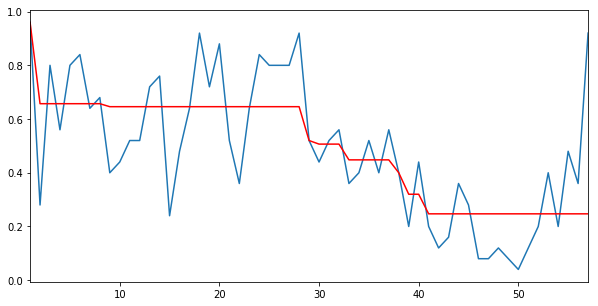

<Figure size 720x360 with 0 Axes>

In [7]:
# Fit IsotonicRegression
x = list(range(1,len(counts)+1))
y = counts.values
ir = IsotonicRegression(increasing='auto')
y_ = ir.fit_transform(x, y)
fig=counts.plot()
fig.plot(x,y_, c='red')
plt.show()
plt.savefig("entire_mono.png")

In [8]:
meets_condition(df)

False

In [9]:
dd = top25_dfs[4].drop('Division', axis=1)
top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
df10 = top25_dfs[4].drop('Division', axis=1).loc[top10].rank(ascending=True)
df10.head()

,Rank1,Rank2,Rank3,Rank4,Rank5,Rank6,Rank7,Rank8,Rank9,Rank10,...,Rank16,Rank17,Rank18,Rank19,Rank20,Rank21,Rank22,Rank23,Rank24,Rank
Julio Jones,1.0,3.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,...,1.0,1.0,6.0,3.0,1.0,1.0,3.0,1.0,5.0,1.0
Keenan Allen,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0
DeAndre Hopkins,4.0,4.0,4.0,5.0,3.0,1.0,5.0,3.0,3.0,5.0,...,5.0,2.0,5.0,4.0,4.0,3.0,1.0,3.0,2.0,3.0
Davante Adams,3.0,1.0,3.0,3.0,5.0,5.0,1.0,6.0,6.0,3.0,...,9.0,5.0,1.0,1.0,2.0,10.0,5.0,5.0,1.0,5.0
Odell Beckham Jr.,6.0,5.0,5.0,8.0,4.0,8.0,6.0,4.0,7.0,6.0,...,6.0,4.0,7.0,5.0,5.0,5.0,4.0,4.0,8.0,4.0


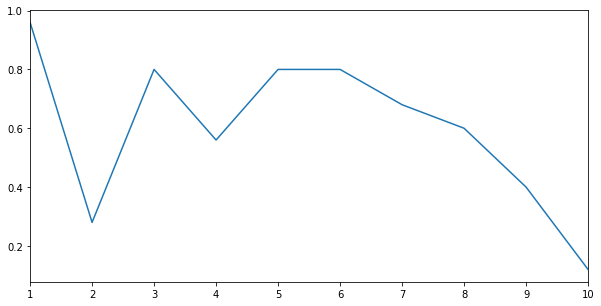

In [10]:
df10 = df10[top25_dfs[4].loc[top10]['Division']==1.]

dfs=[]
for c in df10.columns.values:
    dfs.append(df10[c].value_counts())
counts10 = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/25
counts10.plot()

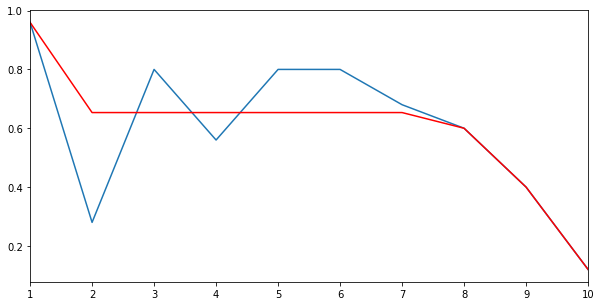

In [11]:
# Fit IsotonicRegression
x = list(range(1,len(counts10)+1))
y = counts10.values
ir = IsotonicRegression(increasing='auto')
y_ = ir.fit_transform(x, y)
fig=counts10.plot()
fig.plot(x,y_, c='red')
plt.show()

**Evaluate all fairness metrics**

**evaluate metrics week to week to verify meeting condition predicts behavior**

In [12]:
#rank_parity method from the FARE repo gives the normalized absolute difference of the rpar scores for each group
# If you want to compute the pairwise advantage for each group separately you can use this method

from fare.metrics import _count_inversions,_merge_parity,_merge_eq

def rank_parity(y,groups):
    r = np.transpose([y,groups])
    r = r[r[:,0].argsort()]
    g= np.array(r[:,1], dtype=int)
    e0 = _count_inversions(g, 0, len(g)-1, _merge_parity, 0)[1]
    e1 = _count_inversions(g, 0, len(g)-1, _merge_parity, 1)[1]

    return e0,e1

In [13]:
# $rKL$, $rRD$, $rND$, $expRR$, $expDCG$, and $rPar$ : key metrics
def getMetrics(window, ranking, sensi_idx):
    
    rank_len=len(ranking)
    r = len(sensi_idx)
    
    msn = []
    
    #get max vals for normalization
    max_rKL = getNormalizer(rank_len,r,KL_DIVERGENCE,window)  
    max_rND = getNormalizer(rank_len,r,ND_DIFFERENCE,window) 
    max_rRD = getNormalizer(rank_len,r,RD_DIFFERENCE,window) 
    normRR = getExpRRNormalizer(rank_len,r/rank_len)
    normDCG = getExpRRNormalizer(rank_len,r/rank_len)  

    #calculate normalized values
    fair_rND = calculateNDFairness(ranking, sensi_idx, window,ND_DIFFERENCE,max_rND)
    fair_rRD = calculateNDFairness(ranking, sensi_idx, window,RD_DIFFERENCE,max_rRD)
    fair_rKL = calculateNDFairness(ranking, sensi_idx, window,KL_DIVERGENCE,max_rKL)
            
    rr = calculaterExpRR(ranking, sensi_idx, rank_len, r)
    fair_expRR = (rr - normRR[0])/(normRR[1] - normRR[0])
    dcg = calculaterExpDCG(ranking, sensi_idx, rank_len, r)
    fair_expDCG = (dcg - normDCG[0])/(normDCG[1] - normDCG[0])
    
    groups = [0 if x in sensi_idx else 1 for x in np.arange(rank_len)]
    e0,e1 = rank_parity(np.arange(rank_len), groups)
    n_pairs = r*(rank_len-r)
    fair_Rpar = abs(e0 - e1)/n_pairs 
    
    msn.append([fair_rND, fair_rKL, fair_expRR, fair_expDCG, fair_Rpar, fair_rRD])

    cols = ['rND','rKL', 'expRR', 'expDCG', 'Rpar', 'rRD']
    return pd.DataFrame(msn, columns=cols)

In [14]:
meets={}
doesnt_meet={}
meets10={}
doesnt_meet10={}

for week in range(1,17):
    df = top25_dfs[week].drop('Division', axis=1).rank(ascending=True)
    df = df[top25_dfs[week]['Division']==1.]
    if meets_condition(df):
        meets[week]=df
    else:
        doesnt_meet[week]=df

for week in range(1,17):
    df = dfs10[week].drop('Division', axis=1).rank(ascending=True)
    df = df[dfs10[week]['Division']==1.]
    if meets_condition(df):
        meets10[week]=df
    else:
        doesnt_meet10[week]=df

In [15]:
def plot_metrics(dfs, weeks, window):
    #compute the expected (average) metric values each week for full rankings
    cols = ['rND','rKL', 'expRR', 'expDCG', 'Rpar', 'rRD']
    metrics = pd.DataFrame()

    for week in weeks:
        df = dfs[week].drop('Division', axis=1).rank(ascending=True)
        df['Division'] = dfs[week]['Division']
        ms = pd.DataFrame(columns=cols)
        for c in df.drop('Division',axis=1).columns.values:
            ranking = df[[c,'Division']].sort_values(c)
            sensi_idx = [i for i,x in enumerate(ranking['Division'].values) if x==0]
            rank = ranking[c].astype(int)
            ms= pd.concat([ms,getMetrics(window, rank, sensi_idx)])
        metrics[week]=ms.mean()
    metrics.transpose().plot()
    plt.show()
    plt.clf()
    corr = metrics.transpose().corr().as_matrix()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, vmin=-1, mask=mask, vmax=1, annot=True, center=0,cmap=sns.diverging_palette(20, 220, n=200),
                                 square=True, cbar=False)


    ax.set_xticklabels(metrics.index.values,rotation=45,horizontalalignment='right')
    ax.set_yticklabels(metrics.index.values,rotation=45,horizontalalignment='right')

entire, meets condition


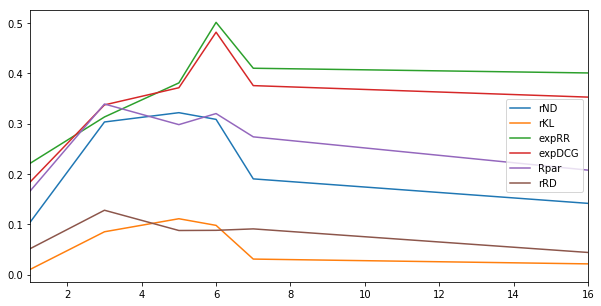

entire, doesn't meet condition


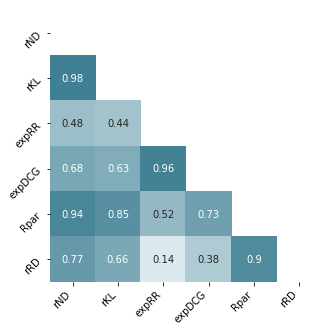

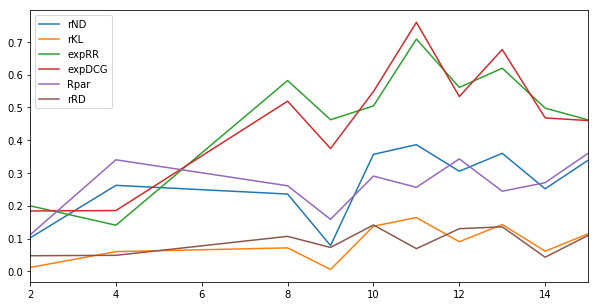

top 10, meets condition


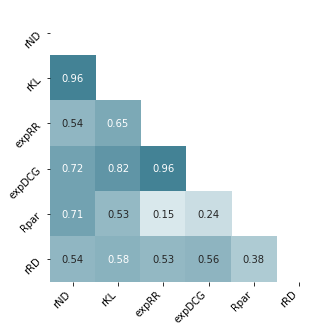

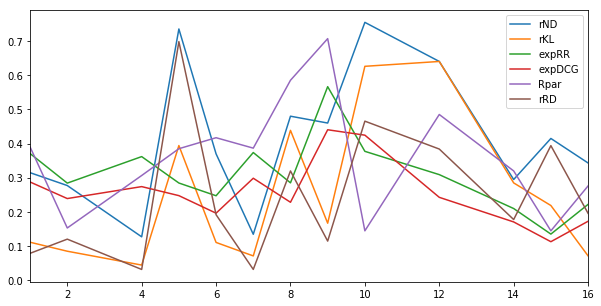

top 10, doesn't meet condition


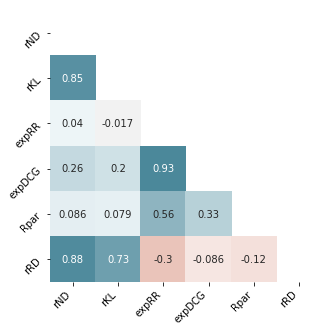

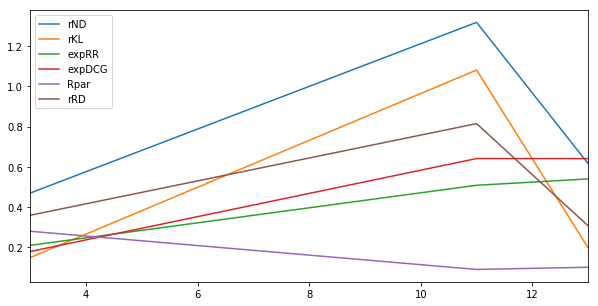

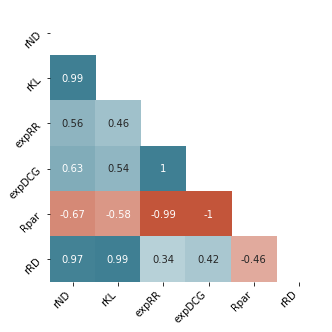

In [16]:
print("entire, meets condition")
plot_metrics(top25_dfs, meets.keys(), 10)
print("entire, doesn't meet condition")
plot_metrics(top25_dfs, doesnt_meet.keys(), 10)
print("top 10, meets condition")
plot_metrics(dfs10, meets10.keys(), 5)
print("top 10, doesn't meet condition")
plot_metrics(dfs10, doesnt_meet10.keys(), 5)

** LOAD DATA -- ALL EXPERTS -- MULTIPLE POSITIONS**

In [9]:
# all experts' rankings of players for 16 weeks of the season (experts who ranked players every week)
# all_dfs is a dictionary containing dataframes of rankings for each player position.
# all_dfs[position] is a dictionary of rankings for each week.
# there are roughly 90 experts (varies across positions, and different numbers of players per position) 
# each column is a ranking players. The last column "Division" gives the group labels for each player

pkl_file = open('all_dfs.pickle', 'rb')
all_dfs = pickle.load(pkl_file)
pkl_file.close()
positions = ['WR','QB','RB','TE']

In [10]:
dfs_QB = all_dfs['QB']

In [12]:
df = dfs_QB[4].drop('Division', axis=1).rank(ascending=True)
df.shape


(18, 90)

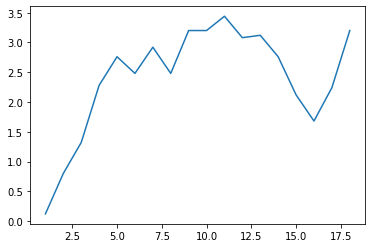

In [4]:
# Check monotonicity for a single week

df = dfs_QB[4].drop('Division', axis=1).rank(ascending=True)
df = df[dfs_QB[4]['Division']==1.]
# r1 = df[df['Division']==0.]['Rank1'].value_counts()
# r2 = df[df['Division']==0.]['Rank2'].value_counts()
dfs=[]
for c in df.columns.values:
    dfs.append(df[c].value_counts())
counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/25
counts.plot()
plt.savefig("entire.png")

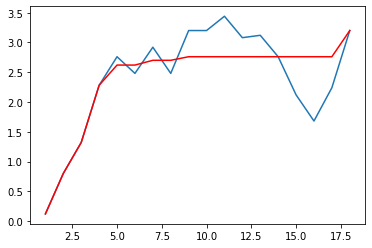

<Figure size 432x288 with 0 Axes>

In [8]:
# Fit IsotonicRegression
x = list(range(1,len(counts)+1))
y = counts.values
ir = IsotonicRegression(increasing='auto')
y_ = ir.fit_transform(x, y)
fig=counts.plot()
fig.plot(x,y_, c='red')
plt.show()
plt.savefig("entire_mono.png")

In [6]:
meets_condition(df)

NameError: name 'meets_condition' is not defined